In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from data_loader import load_track_data, load_race_data
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import math

from data_loader import transform_coordinates


In [3]:
track_left_side, track_right_side = load_track_data(distance_pr_dot = 1)
track_left_side

c:\GitHub\RacingTrajectories\data_loader.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_left_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_leftside_raw.csv', index_col=False)
c:\GitHub\RacingTrajectories\data_loader.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_right_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_rightside_raw.csv', index_col=False)


,Timestamp,Y-Coords,Z-Coords,X-Coords
0,12.072,2.187290,63.983009,764.897095
140,14.259,2.231630,63.973942,763.882812
167,14.685,2.268255,63.964184,762.850464
188,0.192,2.300150,63.956116,761.810608
205,0.456,2.328267,63.948250,760.798889
...,...,...,...,...
27248,1.818,2.557289,63.860271,742.016357
27255,1.929,2.577993,63.858112,740.951294
27263,2.052,2.597204,63.851013,739.898376
27272,2.193,2.613663,63.841419,738.897644


c:\GitHub\RacingTrajectories\data_loader.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_left_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_leftside_raw.csv', index_col=False)
c:\GitHub\RacingTrajectories\data_loader.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_right_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_rightside_raw.csv', index_col=False)


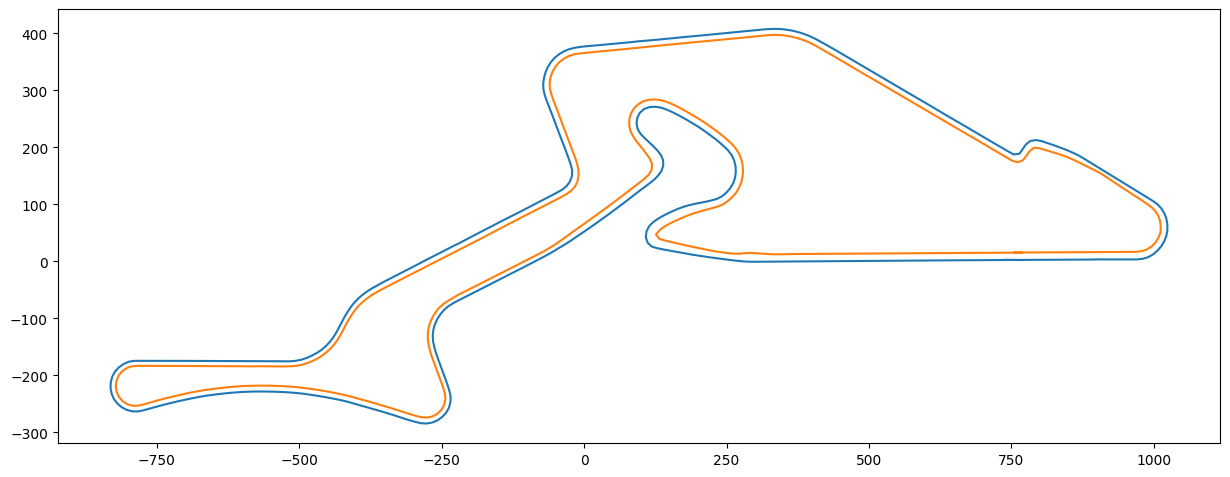

In [4]:
# Plot the reduced track in 2D using matplotlib
track_left_side, track_right_side = load_track_data(distance_pr_dot = 10)
fig, ax = plt.subplots()
ax.plot(track_left_side['X-Coords'],track_left_side['Y-Coords'])
ax.plot(track_right_side['X-Coords'],track_right_side['Y-Coords'] )
ax.set_aspect('equal')
fig.set_size_inches(15, 10)
plt.show()

In [5]:
# Import real left and right track data. from ./Data/Map_details/Left_boundary.csv and Right_boundary.csv
### NOTE ONLY RUN ONCE

for txt_file in ['Left_boundary', 'Right_boundary']:
    with open(f'./Data/Map_details/{txt_file}.txt', 'r') as f:
        # left_boundary = pd.read_csv(f)
        boundary = f.readlines()
        boundary = [x.split() for x in boundary][0]
        boundary = [x[:-2] for x in boundary]
        boundary = [x.split(',') for x in boundary]

        df_boundary = pd.DataFrame(boundary, columns = ['Longitude', 'Latitude'])
        # save to csv file
        df_boundary.to_csv(f'./Data/Map_details/{txt_file}.csv', index = False)


In [6]:
real_track_left_side  = pd.read_csv('./Data/Map_details/Left_boundary.csv')
real_track_right_side = pd.read_csv('./Data/Map_details/Right_boundary.csv')
real_track_right_side

,Longitude,Latitude
0,6.947242,50.335378
1,6.947557,50.335586
2,6.947965,50.335849
3,6.948183,50.335997
4,6.948543,50.336224
...,...,...
388,6.943929,50.333223
389,6.944191,50.333396
390,6.944691,50.333727
391,6.947055,50.335270


## NOTE FOR TRANSFORMATION : 

The transformation process was as followed. 
1. Try to allign the 2 u-turns above the center piece.
2. Allign the turn which is directly below the center piece, as the vertical allignment should 
3. Re-allign the 2 u-turns above the center piece, as the horizontal allignment should be correct now.
4. Check the error of rotation of the top right part, and left bottom part of the track, and rotate accordingly 
5. Re-allign the 2 u-turns above the center piece, as the horizontal allignment should be correct now.
6. Check the error of rotation of the top right part, and left bottom part of the track, and rotate accordingly (smaller)
7. Re-allign the 2 u-turns above the center piece, as the horizontal allignment should be correct now.
8. Confirm that the track rotation is correct, and the scale is almost correct.
9. find the left most part of the track, and the right most part of the track. Allign by the x-axis with shifts and scale.
10. find the top most part of the track, and the bottom most part of the track. Allign by the y-axis with shifts and scale.

This process seemed to result in the most accurate transformation of the track, although it is not perfect.

In [279]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def calc_track_length(track_df):
    """
    Calculate the length of the track in km
    """
    length = 0
    try:
        latitude = track_df['Latitude'].to_list()
        longitude = track_df['Longitude'].to_list()
    except KeyError:
        latitude = track_df['Y-Coords'].to_list()
        longitude = track_df['X-Coords'].to_list()

    for i in range(len(longitude)-1):
        length += haversine_distance(latitude[i], longitude[i], latitude[i+1], longitude[i+1])
    return length


rotation_angle = 45.1 # More is left, less is to the right
scale_x = 0.000014055
scale_y = 0.000008965
shift_x = 6.940315
shift_y = 50.33069
center_x = 0
center_y = 0



Transformed Left Track Length:  5.184497092707903
Real Left Track Length:         5.187256161031783

Transformed Left Track Right:  5.081739512152493
Real Right Track Length:       5.085862132061388


In [328]:

def plot_track(track_left, track_right, real_track_left_side, real_track_right_side):
    # plot the track, but use plotly for interactivity
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=track_left['X-Coords'], y=track_left['Y-Coords'], mode='lines', name='Track Left', line=dict(width=0.8)))
    fig.add_trace(go.Scatter(x=track_right['X-Coords'], y=track_right['Y-Coords'], mode='lines', name='Track Right', line=dict(width=0.8)))
    fig.add_trace(go.Scatter(x=real_track_left_side['Longitude'], y=real_track_left_side['Latitude'], mode='lines', name='Real Track Left', line=dict(width=0.8)))
    fig.add_trace(go.Scatter(x=real_track_right_side['Longitude'], y=real_track_right_side['Latitude'], mode='lines', name='Real Track Right', line=dict(width=0.8)))
    fig.update_layout(title='Track Comparison', xaxis_title='Longitude', yaxis_title='Latitude')

    # plot a center point for the track as the shift_x, shift_y
    shift_x = 6.940328
    shift_y = 50.3307159
    fig.add_trace(go.Scatter(x=[shift_x], y=[shift_y], mode='markers', name='Center Point'))
    
    # change size of the plot
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
    )

    #ALL
    default_zoom_x = [6.933, 6.951]  # Replace these with your desired x-axis range
    default_zoom_y = [50.324, 50.338]  # Replace these with your desired y-axis range

    # # Bottom Left
    default_zoom_x = [6.9339, 6.9357]  # Replace these with your desired x-axis range
    default_zoom_y = [50.3238, 50.3252]  # Replace 

    # Top Right
    # default_zoom_x = [6.9479, 6.951]  # Replace these with your desired x-axis range
    # default_zoom_y = [50.3355, 50.338]  # Replace 

    # # Mid
    # default_zoom_x = [6.938, 6.942]  # Replace these with your desired x-axis range
    # default_zoom_y = [50.3305, 50.334]  # Replace 

    fig.update_xaxes(range=default_zoom_x)
    fig.update_yaxes(range=default_zoom_y)
    
    fig.show()


rotation_angle = 45.15 # More is left, less is to the right
scale_x = 0.00001406
scale_y = 0.000009005
shift_x = 6.940315
shift_y = 50.330715
center_x = 0
center_y = 0



trans_track_left = transform_coordinates(track_left_side,rotation_angle, scale_x  ,scale_y  ,  shift_x  ,  shift_y  , center_x ,center_y )
trans_track_right = transform_coordinates(track_right_side,rotation_angle,scale_x  ,scale_y  ,  shift_x  ,  shift_y  , center_x ,center_y )

trans_track_left = transform_coordinates(track_left_side,rotation_angle, scale_x  ,scale_y  ,  shift_x  ,  shift_y  , center_x ,center_y )
trans_track_right = transform_coordinates(track_right_side,rotation_angle,scale_x  ,scale_y  ,  shift_x  ,  shift_y  , center_x ,center_y )


print("Transformed Left Track Length: ",calc_track_length(trans_track_left))
print("Real Left Track Length:        ",calc_track_length(real_track_left_side))
print("")
print("Transformed Left Track Right: ",calc_track_length(trans_track_right))
print("Real Right Track Length:      ",calc_track_length(real_track_right_side))


plot_track(track_left = trans_track_left, track_right = trans_track_right, 
            real_track_left_side = real_track_left_side, 
            real_track_right_side = real_track_right_side)

Transformed Left Track Length:  5.197604142646424
Real Left Track Length:         5.187256161031783

Transformed Left Track Right:  5.094590104974888
Real Right Track Length:       5.085862132061388


In [ ]:
# create a function which converts the dataframe to latitudinal and longitudinal coordinates

def convert_df_to_lat_long(left_df, right_df):
    # convert the dataframe to latitudinal and longitudinal coordinates

    # return geo_df

geo_df = convert_df_to_lat_long(df)

IndentationError: expected an indented block (274707634.py, line 8)

In [ ]:

def summarize_graph(G):
    # Basic information
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    
    # More detailed analysis
    components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    largest_component = max(components, key=len)
    diameter = nx.diameter(largest_component) if num_components == 1 else 'Undefined for disconnected graphs'
    density = nx.density(G)
    
    # Summary
    print(f'Number of Nodes: {num_nodes}')
    print(f'Number of Edges: {num_edges}')
    print(f'Number of Connected Components: {num_components}')
    print(f'Average Degree: {avg_degree:.2f}')
    print(f'Diameter of the Largest Component: {diameter}')
    print(f'Graph Density: {density:.4f}')


def create_left_right_pairs(df_left, df_right):
    pass

def is_point_within_track():
    pass


def create_track_network(df_left_reduced, df_right_reduced, grid_distance, diagonally_connected):
    
    # Interpolate boundaries
    left_spline_x, left_spline_y, right_spline_x, right_spline_y = create_cubic_splines(df_left_reduced, df_right_reduced)
    
    # Determine the vertical bounds of the track
    min_y = min(df_left_reduced['Y-Coords'].min(), df_right_reduced['Y-Coords'].min())
    max_y = max(df_left_reduced['Y-Coords'].max(), df_right_reduced['Y-Coords'].max())
    
    # Create the grid of nodes, checking if each is within track boundaries
    valid_nodes = []
    for y in np.arange(min_y, max_y, grid_distance):
        for x in np.arange(df_left_reduced['X-Coords'].min(), df_right_reduced['X-Coords'].max(), grid_distance):
            if REPLACE WITH FUNCTION TO CHECK IF POINT IS WITHIN TRACK:
                valid_nodes.append((x, y))

    # Create the network graph from the valid nodes
    G = nx.Graph()
    for node in valid_nodes:
        G.add_node(node)
    
    # Add edges based on grid_distance, include diagonals if specified
    directions = [(0, grid_distance), (grid_distance, 0)]
    if diagonally_connected:
        directions.extend([(grid_distance, grid_distance), (-grid_distance, grid_distance)])
    
    for node in valid_nodes:
        x, y = node
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor in valid_nodes:
                G.add_edge(node, neighbor)
    
    return G


G = create_track_network(track_left_side, track_right_side, grid_distance = 5, diagonally_connected= True)
summarize_graph(G)

ValueError: `x` must be strictly increasing sequence.

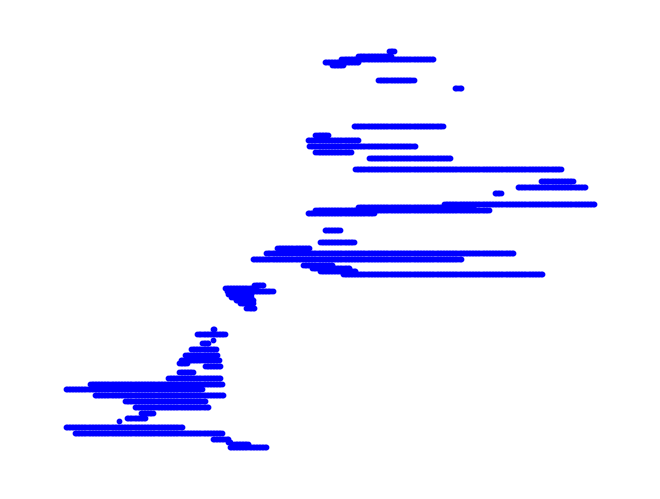

In [ ]:

def visualize_and_save_graph(G, file_name, dpi=300):
    # Set the size of the figure
    ax.set_aspect('equal')
    fig.set_size_inches(15, 15)
    plt.show()
    
    # Extract node positions from the graph G
    pos = {node: (node[0], node[1]) for node in G.nodes()}
    
    # Draw the network
    nx.draw(G, pos, node_size=10, width=1, with_labels=False, node_color='blue', edge_color='gray')
    
    plt.show()
    # Save the figure
    # plt.savefig(file_name, format='png', dpi=dpi, bbox_inches='tight')
    # plt.close()  # Close the figure to free memory

# Example usage:
visualize_and_save_graph(G, 'Data/Map_details/track_network.png', dpi=300)
